In [5]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import os
from glob import glob
from keras.preprocessing.image import load_img, img_to_array
import multiprocessing as mp 
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from huggingface_hub import from_pretrained_keras


In [4]:
def load_data(files, start=0, end=10):
    X = []
    y = []
    for f in files[start:end]:
        img = load_img(f, target_size=(50, 50))
        sample = tf.convert_to_tensor(img)
        X.append(sample)
        y.append(f[-5])
    return np.array(files[start:end]), np.stack(X), np.array(y, dtype=float)

In [60]:
from huggingface_hub import from_pretrained_keras

files = glob('../data/*/*/*.png')
print(f'Total images: {len(files)}')
chunk_size = 10000
chunks = [(chunk_size*i, chunk_size*(i+1)) for i in range(int(len(files)/chunk_size) + 1)]

bc_model = keras.models.load_model("../models/CanDetect.keras")

for chunk in chunks:
    start, end = chunk
    file_names, x, y = load_data(files, start=start, end=end)
    print(f'processing {chunk=}')
    predictions_logits = bc_model.predict(x)
    np.savetxt(f'model_output_{start}_{end}', np.column_stack((file_names, predictions_logits, y)), fmt="%s", delimiter=',', header="file,pred_y,true_y")


Total images: 277524
processing chunk=(0, 10000)
313/313 [==============================] - 116s 371ms/step
processing chunk=(10000, 20000)
313/313 [==============================] - 118s 377ms/step
processing chunk=(20000, 30000)
313/313 [==============================] - 119s 380ms/step
processing chunk=(30000, 40000)
313/313 [==============================] - 121s 386ms/step
processing chunk=(40000, 50000)
313/313 [==============================] - 119s 382ms/step
processing chunk=(50000, 60000)
313/313 [==============================] - 119s 381ms/step
processing chunk=(60000, 70000)
313/313 [==============================] - 127s 405ms/step
processing chunk=(70000, 80000)
313/313 [==============================] - 120s 384ms/step
processing chunk=(80000, 90000)
313/313 [==============================] - 120s 385ms/step
processing chunk=(90000, 100000)
313/313 [==============================] - 121s 386ms/step
processing chunk=(100000, 110000)
313/313 [=============================

In [61]:
import pandas as pd
chunks = [(chunk_size*i, chunk_size*(i+1)) for i in range(int(len(files)/chunk_size) + 1)]

# Assuming you have three CSV files: 'file1.csv', 'file2.csv', and 'file3.csv'
file_paths = [f'model_output_{chunk[0]}_{chunk[1]}' for chunk in chunks]

# Read each CSV file into a DataFrame
dfs = [pd.read_csv(file_path) for file_path in file_paths]

# Concatenate the DataFrames along the rows (axis=0)
result = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame to a new CSV file
result.to_csv('all_outputs.csv', index=False)


<Axes: >

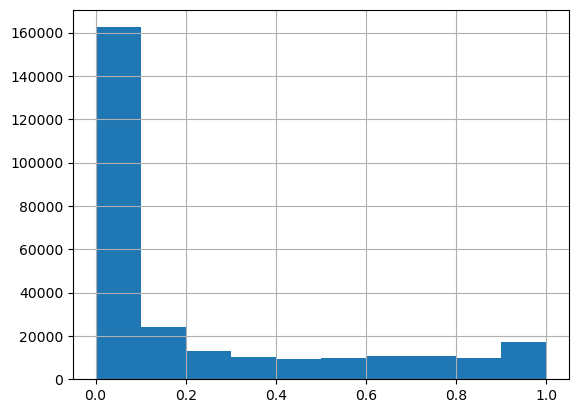

In [8]:
result = pd.read_csv('all_outputs.csv')
result['pred_y'].hist()

[[191196   7542]
 [ 27941  50845]]


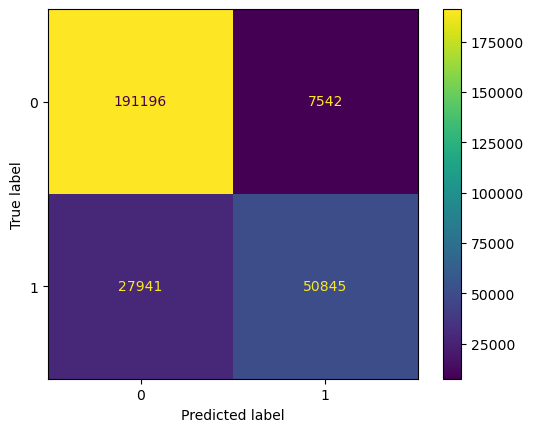

In [92]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y = result['true_y']
y_pred = result['pred_y']
predictions_clss = np.where(y_pred > 0.5, 1, 0)

print(confusion_matrix(y, predictions_clss))
cm = confusion_matrix(y, predictions_clss)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
# print(classification_report(y, predictions_clss))

In [105]:
# df = result[result['pred_y'] > 0.5]
df = result
df = df[df['true_y'] == 1] # mistakes -- no tumor for samples with tumor
# df

In [7]:
import seaborn as sns

df = result
df = df[df['true_y'] == 1]
sns.histplot(df['pred_y'])

df = result
df = df[df['true_y'] == 0]
sns.histplot(df['pred_y'])


NameError: name 'result' is not defined

In [10]:
np.random.seed(42)
sample = np.random.randint(0, len(result), 100)

In [4]:
result = pd.read_csv('all_outputs.csv')
result.iloc[sample]

NameError: name 'pd' is not defined

In [2]:
from sklearn.metrics import accuracy_score
bc_model = keras.models.load_model("../models/CanDetect.keras")

files = result.iloc[sample]['# file']
file_names, x, y = load_data(files, start=0, end=len(files))
predictions_logits = bc_model.predict(x)
y_sample = result.iloc[sample]['true_y']
predictions_clss = np.where(predictions_logits > 0.5, 1, 0)

print(confusion_matrix(y_sample, predictions_clss))
print(accuracy_score(y_sample, predictions_clss))

NameError: name 'keras' is not defined

In [1]:
def load_data_with_augment(files, start=0, end=10): #same accuracy for 90,180, 270 rotation
    X = []
    y = []
    for f in files[start:end]:
        img = load_img(f, target_size=(50, 50))
        print(f'process file {f}')
        img = img.convert("L")
        sample = tf.convert_to_tensor(img)
        X.append(sample)
        y.append(f[-5])
    return np.array(files[start:end]), np.stack(X), np.array(y, dtype=float)

In [ ]:
files = result.iloc[sample]['# file']
file_names, x, y = load_data_with_augment(files, start=0, end=len(files))
predictions_logits = bc_model.predict(x)
y_sample = result.iloc[sample]['true_y']
predictions_clss = np.where(predictions_logits > 0.5, 1, 0)

print(confusion_matrix(y_sample, predictions_clss))
print(accuracy_score(y_sample, predictions_clss))

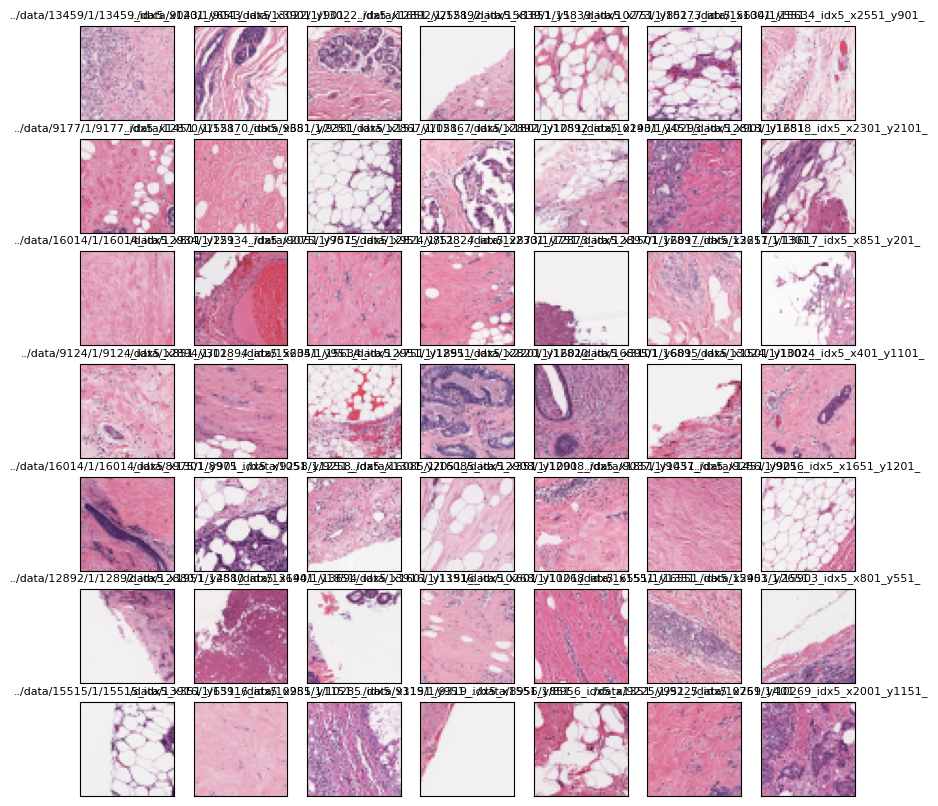

In [91]:
def plot_imgs(paths):
    fig, axes = plt.subplots(7,7,figsize=(10,10))
    for path, ax in zip(paths, axes.flatten()):
        #Load the image
        img = load_img(path)
        #Plot theimage
        ax.imshow(img)
        #Set image properties
        ax.set_title(label=path[:-10], fontdict={"fontsize":8})
        ax.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
        
plot_imgs(df.iloc[sample]['# file'])        

In [15]:
file_names, x, y = load_data(files, start=0, end=1000)
pred = test_model.predict(x)

32/32 [==============================] - 25s 766ms/step


In [21]:
test_loss, test_acc = test_model.evaluate(x)


32/32 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


In [24]:
test_acc

0.0

In [25]:
img = load_img('/home/monika/Moje/ML-sem-III/eml2023/project/IDC_regular_ps50_idx5/9022/1/9022_idx5_x2651_y1201_class1.png')

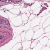

In [26]:
img

In [30]:
model = from_pretrained_keras('MUmairAB/Breast_Cancer_Detector')


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [32]:
files = glob('/home/monika/Moje/ML-sem-III/eml2023/project/IDC_regular_ps50_idx5/9022/1/*.png')
files

['/home/monika/Moje/ML-sem-III/eml2023/project/IDC_regular_ps50_idx5/9022/1/9022_idx5_x2401_y1101_class1.png',
 '/home/monika/Moje/ML-sem-III/eml2023/project/IDC_regular_ps50_idx5/9022/1/9022_idx5_x2651_y1101_class1.png',
 '/home/monika/Moje/ML-sem-III/eml2023/project/IDC_regular_ps50_idx5/9022/1/9022_idx5_x2601_y1151_class1.png',
 '/home/monika/Moje/ML-sem-III/eml2023/project/IDC_regular_ps50_idx5/9022/1/9022_idx5_x2551_y1201_class1.png',
 '/home/monika/Moje/ML-sem-III/eml2023/project/IDC_regular_ps50_idx5/9022/1/9022_idx5_x2301_y1351_class1.png',
 '/home/monika/Moje/ML-sem-III/eml2023/project/IDC_regular_ps50_idx5/9022/1/9022_idx5_x2101_y1201_class1.png',
 '/home/monika/Moje/ML-sem-III/eml2023/project/IDC_regular_ps50_idx5/9022/1/9022_idx5_x2401_y901_class1.png',
 '/home/monika/Moje/ML-sem-III/eml2023/project/IDC_regular_ps50_idx5/9022/1/9022_idx5_x2651_y1201_class1.png',
 '/home/monika/Moje/ML-sem-III/eml2023/project/IDC_regular_ps50_idx5/9022/1/9022_idx5_x2651_y1051_class1.png',
 '

In [54]:
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from huggingface_hub import from_pretrained_keras
import numpy as np


def detect_cancer(img):
    #Load the model
    global model
    #Convert the NumPy image to tensor
    img = tf.convert_to_tensor(img)
    #Convert the single images to batch image
    img = tf.expand_dims(img, axis=0)
    #Make predictions
    pred = model.predict(img)
    #Convert the "numpy.ndarray" object to a simple numebr
    prediction = round(float(pred))
    print(pred, prediction)
    return pred, prediction
    # if prediction == 0:
        # return("Congratulation! you don't have breast cancer")
    # else:
    #     return("Unfortunately! you have breast cancer. Kindly consult a doctor!")
  
x1 = []
x2 = []
imgs = [load_img(f) for f in files]
imgs = tf.convert_to_tensor(imgs)
# pred = model.predict(imgs)


# for f in files:
#     img = load_img(f)
#     res = detect_cancer(img)
#     x1.append(res[0][0][0])
#     x2.append(res[1])
    

ValueError: Attempt to convert a value (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x7FBC9E3078D0>) with an unsupported type (<class 'PIL.PngImagePlugin.PngImageFile'>) to a Tensor.

In [57]:
# plt.hist(x1, bins=2)
# plt.hist(x2)
# x1
imgs[0]
tf.convert_to_tensor(imgs[0])


<tf.Tensor: shape=(50, 50, 3), dtype=uint8, numpy=
array([[[165, 132, 171],
        [154, 112, 159],
        [185, 143, 180],
        ...,
        [144,  94, 143],
        [135,  92, 141],
        [145, 107, 151]],

       [[162, 127, 166],
        [162, 118, 160],
        [186, 139, 173],
        ...,
        [177, 148, 180],
        [152,  99, 145],
        [190, 148, 185]],

       [[168, 134, 170],
        [159, 115, 157],
        [188, 142, 177],
        ...,
        [135,  91, 143],
        [112,  68, 118],
        [146, 106, 146]],

       ...,

       [[197, 162, 191],
        [197, 170, 193],
        [189, 145, 179],
        ...,
        [170, 120, 166],
        [188, 141, 178],
        [184, 131, 172]],

       [[170, 128, 170],
        [163, 127, 171],
        [185, 146, 180],
        ...,
        [181, 139, 177],
        [181, 137, 176],
        [197, 147, 180]],

       [[203, 168, 195],
        [163, 127, 166],
        [185, 145, 181],
        ...,
        [180, 139, 177]

In [58]:
img_to_array(imgs[0])

array([[[165., 132., 171.],
        [154., 112., 159.],
        [185., 143., 180.],
        ...,
        [144.,  94., 143.],
        [135.,  92., 141.],
        [145., 107., 151.]],

       [[162., 127., 166.],
        [162., 118., 160.],
        [186., 139., 173.],
        ...,
        [177., 148., 180.],
        [152.,  99., 145.],
        [190., 148., 185.]],

       [[168., 134., 170.],
        [159., 115., 157.],
        [188., 142., 177.],
        ...,
        [135.,  91., 143.],
        [112.,  68., 118.],
        [146., 106., 146.]],

       ...,

       [[197., 162., 191.],
        [197., 170., 193.],
        [189., 145., 179.],
        ...,
        [170., 120., 166.],
        [188., 141., 178.],
        [184., 131., 172.]],

       [[170., 128., 170.],
        [163., 127., 171.],
        [185., 146., 180.],
        ...,
        [181., 139., 177.],
        [181., 137., 176.],
        [197., 147., 180.]],

       [[203., 168., 195.],
        [163., 127., 166.],
        [185., 1